In [ ]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
import timeit
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

### Autoencoder class

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(AutoEncoder, self).__init__()
        #Encoder
        self.enc1 = nn.Linear(784, 256) # Input image (28*28 = 784)
        self.enc2 = nn.Linear(256, 128)
        self.enc3 = nn.Linear(128, 64)
        self.enc4 = nn.Linear(64, 32)
        self.enc5 = nn.Linear(32, 16)

        #Decoder 
        self.dec1 = nn.Linear(16, 32)
        self.dec2 = nn.Linear(32, 64)
        self.dec3 = nn.Linear(64, 128)
        self.dec4 = nn.Linear(128, 256)
        self.dec5 = nn.Linear(256, 784) # Output image (28*28 = 784)


    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))

        return x



### Setting device to GPU to speed up

In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#### Hyperparameters of our neural network which depends on the dataset

In [ ]:
# Hyperparameters of our neural network which depends on the dataset, and
# also just experimenting to see what works well (learning rate for example).
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64

#### Loading training and testing dataset

In [ ]:
# Load Training and Test data
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


#### Reseting parameters of model

In [ ]:
def reset_network_params(model):
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()


### Plotting train loss vs epochs

In [ ]:
def plot_loss(train_loss, num_epoch):
  plt.plot(train_loss, '-ro')
  plt.xlabel("Epoch")
  plt.ylabel("Train loss")
  plt.title("Train Loss vs Epoch")

#### Calculating total mse error in reconstruction test images

In [ ]:
def test_image_reconstruct(model, test_loader):
     tot_recons_err = 0.0
     all_reconstructions = []
     for batch in test_loader:
        img, _ = batch
        img = img.to(device)
        img = img.reshape(img.shape[0], -1)
        outputs = model(img)
        actual = img.cpu().numpy()
        reconstructed = outputs.detach().cpu().numpy()
        tot_recons_err += np.sum(np.sqrt(np.sum((actual - reconstructed)**2, axis=1)))
        for img in reconstructed:
          all_reconstructions.append(img.reshape((28,28)))

     return all_reconstructions, tot_recons_err

### Function to display 20 random reconstructed images

In [ ]:
def show_sample_reconstructions(reconstrucions):
  idx = random.sample(range(1, 9999), 20)
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  columns = 4
  rows = 5
  for i in range(0, columns*rows ):
      img = np.random.randint(10, size=(h,w))
      fig.add_subplot(rows, columns, i+1) 
      #print(idx[i])
      plt.imshow(reconstrucions[idx[i]]) 
  plt.show()

### Training

In [ ]:
def train_model(model,  criterion, optimizer,  Epochs=10):
    train_loss = []
    for epoch in range(Epochs):
        running_loss = 0.0
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            #print(img.shape)
            #break
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        #break
        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, Epochs, loss))

        #if (epoch == Epochs-1):
        #    save_decod_img(outputs.cpu().data, epoch)

    return train_loss

#### Loss : mse
#### Optimizer : Adam

In [ ]:
model = AutoEncoder()
model.to(device)
reset_network_params(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss = train_model(model, criterion, optimizer, Epochs=10)
#train_loss = training(model, train_loader, 10)

Epoch 1 of 10, Train Loss: 0.058
Epoch 2 of 10, Train Loss: 0.038
Epoch 3 of 10, Train Loss: 0.032
Epoch 4 of 10, Train Loss: 0.030
Epoch 5 of 10, Train Loss: 0.029
Epoch 6 of 10, Train Loss: 0.027
Epoch 7 of 10, Train Loss: 0.026
Epoch 8 of 10, Train Loss: 0.025
Epoch 9 of 10, Train Loss: 0.024
Epoch 10 of 10, Train Loss: 0.023


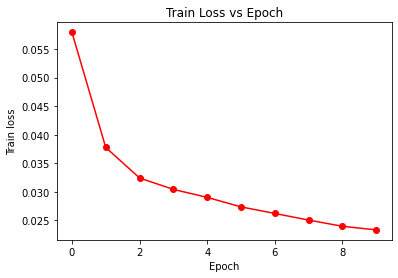

In [ ]:
plot_loss(train_loss, 10)

In [ ]:
all_reconstrucions, tot_recons_err =  test_image_reconstruct(model, test_loader)
print("Total Reconstrucion Error : ",tot_recons_err )
print("Average Reconstrucion Error : ",tot_recons_err/10000 )

Total Reconstrucion Error :  40899.074783325195
Average Reconstrucion Error :  4.0899074783325196


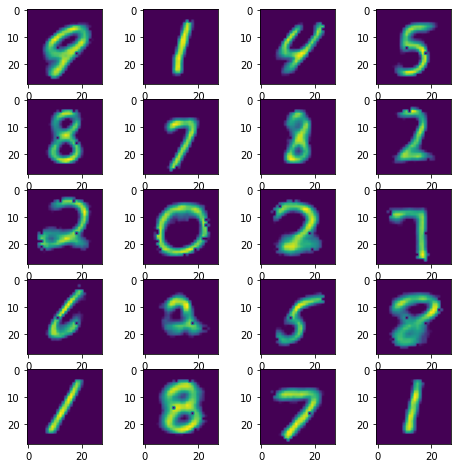

In [ ]:
show_sample_reconstructions(all_reconstrucions)

#### Loss : mse
#### Optimizer : RMSProp

In [ ]:
# Initialize network
model2 = AutoEncoder()
model2.to(device)
reset_network_params(model2)

criterion2 = nn.MSELoss()
optimizer2 = optim.RMSprop(model2.parameters(), lr=0.03, alpha=0.8, eps=1e-08, momentum=0)

train_loss = train_model(model2, criterion2, optimizer2, Epochs=10)


Epoch 1 of 10, Train Loss: 36.651
Epoch 2 of 10, Train Loss: 0.068
Epoch 3 of 10, Train Loss: 0.068
Epoch 4 of 10, Train Loss: 0.066
Epoch 5 of 10, Train Loss: 0.065
Epoch 6 of 10, Train Loss: 0.066
Epoch 7 of 10, Train Loss: 0.066
Epoch 8 of 10, Train Loss: 0.065
Epoch 9 of 10, Train Loss: 0.065
Epoch 10 of 10, Train Loss: 0.065


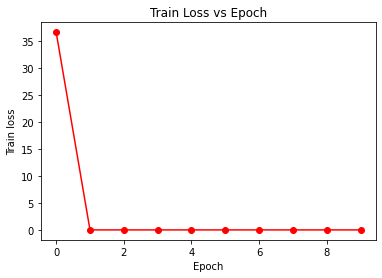

In [ ]:
plot_loss(train_loss, 10)

In [ ]:
all_reconstrucions2, tot_recons_err2 =  test_image_reconstruct(model2, test_loader)
print("Total Reconstrucion Error : ",tot_recons_err2 )
print("Average Reconstrucion Error : ",tot_recons_err2/10000 )

Total Reconstrucion Error :  70742.2261428833
Average Reconstrucion Error :  7.07422261428833


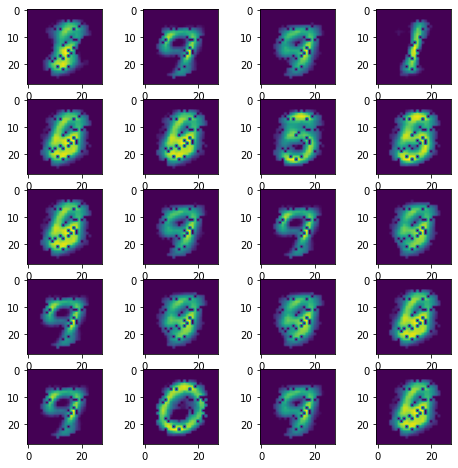

In [ ]:
show_sample_reconstructions(all_reconstrucions2)

#### Loss : mse
#### Optimizer : SGD

In [ ]:
# Initialize network
model3 = AutoEncoder()
model3.to(device)
reset_network_params(model3)

criterion3 = nn.MSELoss()
optimizer3 = optim.SGD(model3.parameters(), lr=0.45, momentum=0.25)

train_loss = train_model(model3, criterion3, optimizer3, Epochs=10)


Epoch 1 of 10, Train Loss: 0.089
Epoch 2 of 10, Train Loss: 0.087
Epoch 3 of 10, Train Loss: 0.086
Epoch 4 of 10, Train Loss: 0.086
Epoch 5 of 10, Train Loss: 0.086
Epoch 6 of 10, Train Loss: 0.086
Epoch 7 of 10, Train Loss: 0.083
Epoch 8 of 10, Train Loss: 0.080
Epoch 9 of 10, Train Loss: 0.078
Epoch 10 of 10, Train Loss: 0.076


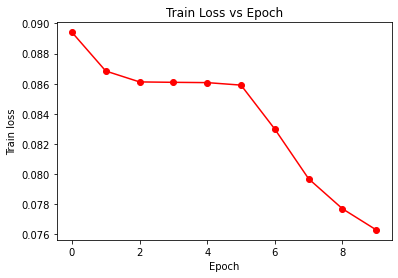

In [ ]:
plot_loss(train_loss, 10)

In [ ]:
all_reconstrucions3, tot_recons_err3 =  test_image_reconstruct(model3, test_loader)
print("Total Reconstrucion Error : ",tot_recons_err3 )
print("Average Reconstrucion Error : ",tot_recons_err3/10000 )

Total Reconstrucion Error :  76391.37889099121
Average Reconstrucion Error :  7.639137889099121


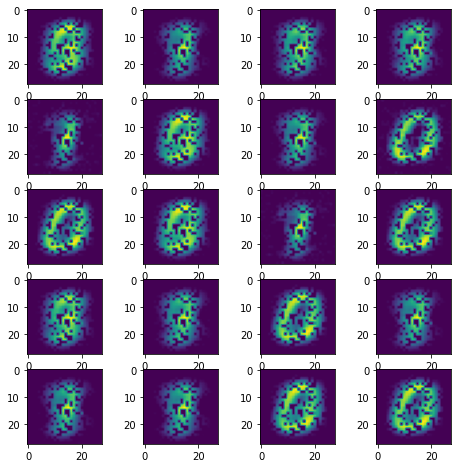

In [ ]:
show_sample_reconstructions(all_reconstrucions3)

### Plot the test reconstruction loss vs hidden neurons for all the above optimizers

#### Autoencoder

In [ ]:
class AutoEncoder2(nn.Module):
    def __init__(self, second_layer_size, input_size=784, num_classes=10):
        super(AutoEncoder2, self).__init__()
        #Encoder
        self.enc1 = nn.Linear(784, second_layer_size) # Input image (28*28 = 784)
        self.enc2 = nn.Linear(second_layer_size, 128)
        self.enc3 = nn.Linear(128, 64)
        self.enc4 = nn.Linear(64, 32)
        self.enc5 = nn.Linear(32, 16)

        #Decoder 
        self.dec1 = nn.Linear(16, 32)
        self.dec2 = nn.Linear(32, 64)
        self.dec3 = nn.Linear(64, 128)
        self.dec4 = nn.Linear(128, second_layer_size)
        self.dec5 = nn.Linear(second_layer_size, 784) # Output image (28*28 = 784)


    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))

        return x



#### We have taken 650, 600, 550, 500, 450, 400 and 350 and number of neurons in 2nd layer of autoencoder.

In [ ]:
snd_layer_size = [650,600,550,500,450,400,350]
AUTOENCS = []
opt = []
for lay_size in snd_layer_size:
  autoEnc = AutoEncoder2(lay_size)
  autoEnc.to(device)
  reset_network_params(autoEnc)
  AUTOENCS.append(autoEnc)
  opt.append(optim.Adam(autoEnc.parameters(), lr=learning_rate))

criterion = nn.MSELoss()
i = 0
for model, optm in zip(AUTOENCS, opt):
  print("TRAINING MODEL WITH",snd_layer_size[i],"NEURONS IN 2ND AND 2ND LAST LAYERS....")
  train_loss = train_model(model, criterion, optm, Epochs=10)
  i += 1

TRAINING MODEL WITH 650 NEURONS IN 2ND AND 2ND LAST LAYERS....
Epoch 1 of 10, Train Loss: 0.052
Epoch 2 of 10, Train Loss: 0.030
Epoch 3 of 10, Train Loss: 0.025
Epoch 4 of 10, Train Loss: 0.023
Epoch 5 of 10, Train Loss: 0.022
Epoch 6 of 10, Train Loss: 0.021
Epoch 7 of 10, Train Loss: 0.021
Epoch 8 of 10, Train Loss: 0.020
Epoch 9 of 10, Train Loss: 0.020
Epoch 10 of 10, Train Loss: 0.019
TRAINING MODEL WITH 600 NEURONS IN 2ND AND 2ND LAST LAYERS....
Epoch 1 of 10, Train Loss: 0.054
Epoch 2 of 10, Train Loss: 0.033
Epoch 3 of 10, Train Loss: 0.028
Epoch 4 of 10, Train Loss: 0.025
Epoch 5 of 10, Train Loss: 0.023
Epoch 6 of 10, Train Loss: 0.022
Epoch 7 of 10, Train Loss: 0.021
Epoch 8 of 10, Train Loss: 0.021
Epoch 9 of 10, Train Loss: 0.020
Epoch 10 of 10, Train Loss: 0.019
TRAINING MODEL WITH 550 NEURONS IN 2ND AND 2ND LAST LAYERS....
Epoch 1 of 10, Train Loss: 0.056
Epoch 2 of 10, Train Loss: 0.035
Epoch 3 of 10, Train Loss: 0.030
Epoch 4 of 10, Train Loss: 0.027
Epoch 5 of 10, Tr

#### Calculating reconstruction error

In [ ]:
recons_err = []
for model in AUTOENCS:
  _, tot_recons_err =  test_image_reconstruct(model, test_loader)
  recons_err.append(tot_recons_err)



#### Plotting reconstrion error vs the 2nd hidden layer size

Text(0.5, 1.0, 'Reconstruction loss vs Hidden Layer neuron')

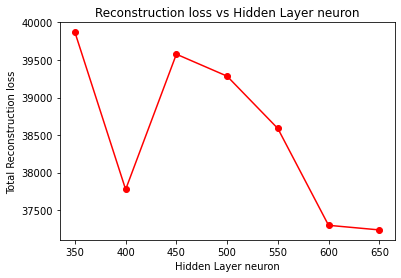

In [ ]:
plt.plot(snd_layer_size,recons_err, '-ro')
plt.xlabel("Hidden Layer neuron")
plt.ylabel("Total Reconstruction loss")
plt.title("Reconstruction loss vs Hidden Layer neuron")

In [ ]:
def func(opt_type):
  snd_layer_size = [650,600,550,500,450,400,350]
  AUTOENCS = []
  opt = []
  for lay_size in snd_layer_size:
    autoEnc = AutoEncoder2(lay_size)
    autoEnc.to(device)
    reset_network_params(autoEnc)
    AUTOENCS.append(autoEnc)
    if (opt_type=="sgd"):
      opt.append(optim.SGD(autoEnc.parameters(), lr=0.45, momentum=0.25))      
    else:
      opt.append(optim.RMSprop(autoEnc.parameters(), lr=0.03, alpha=0.8, eps=1e-08, momentum=0))

  criterion = nn.MSELoss()
  i = 0
  for model, optm in zip(AUTOENCS, opt):
    print("TRAINING MODEL WITH",snd_layer_size[i],"NEURONS IN 2ND AND 2ND LAST LAYERS....")
    train_loss = train_model(model, criterion, optm, Epochs=10)
    i += 1

  recons_err = []
  for model in AUTOENCS:
    _, tot_recons_err =  test_image_reconstruct(model, test_loader)
    recons_err.append(tot_recons_err)

  plt.plot(snd_layer_size,recons_err, '-ro')
  plt.xlabel("Hidden Layer neuron")
  plt.ylabel("Total Reconstruction loss")
  plt.title("Reconstruction loss vs Hidden Layer neuron")

TRAINING MODEL WITH 650 NEURONS IN 2ND AND 2ND LAST LAYERS....
Epoch 1 of 10, Train Loss: 277.261
Epoch 2 of 10, Train Loss: 0.070
Epoch 3 of 10, Train Loss: 0.070
Epoch 4 of 10, Train Loss: 0.070
Epoch 5 of 10, Train Loss: 0.069
Epoch 6 of 10, Train Loss: 0.068
Epoch 7 of 10, Train Loss: 0.068
Epoch 8 of 10, Train Loss: 0.067
Epoch 9 of 10, Train Loss: 0.066
Epoch 10 of 10, Train Loss: 0.068
TRAINING MODEL WITH 600 NEURONS IN 2ND AND 2ND LAST LAYERS....
Epoch 1 of 10, Train Loss: 142.642
Epoch 2 of 10, Train Loss: 0.067
Epoch 3 of 10, Train Loss: 0.068
Epoch 4 of 10, Train Loss: 0.067
Epoch 5 of 10, Train Loss: 0.068
Epoch 6 of 10, Train Loss: 0.069
Epoch 7 of 10, Train Loss: 0.070
Epoch 8 of 10, Train Loss: 0.071
Epoch 9 of 10, Train Loss: 0.072
Epoch 10 of 10, Train Loss: 0.072
TRAINING MODEL WITH 550 NEURONS IN 2ND AND 2ND LAST LAYERS....
Epoch 1 of 10, Train Loss: 182.487
Epoch 2 of 10, Train Loss: 0.068
Epoch 3 of 10, Train Loss: 0.068
Epoch 4 of 10, Train Loss: 0.066
Epoch 5 of 

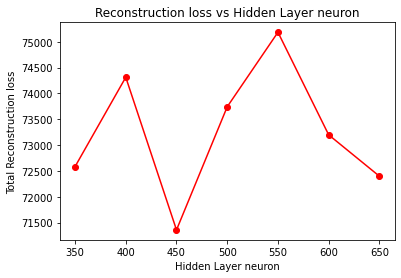

In [ ]:
func("rmsprop")

### PCA reconstruction

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.reshape((x_train.shape[0],-1))
x_train.shape

(60000, 784)

### Getting eigen values and eigen vectors from pca

In [ ]:
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
n_samples =x_train.shape[0]

pca = PCA()
X_transformed = pca.fit_transform(x_train)

# We center the data and compute the sample covariance matrix.
X_centered = x_train - np.mean(x_train, axis=0)
cov_matrix = np.dot(X_centered.T, X_centered) / n_samples
eigenvalues = pca.explained_variance_
for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):    
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
    print(eigenvalue)

### Estimating the eigen values which give > 95% information by dividing by sum of all eigen values

In [ ]:
tot = np.sum(eigenvalues)

Sum = 0
for idx, ev in enumerate(eigenvalues):
  Sum += ev
  info = Sum/tot
  if (info>=0.95):
    print(idx)
    break


153


### First 154 eigen vectors comprise of 95% of the information

### Taking eigen vectors corresponding to the eigen values the sum of whose gave >95% in previous cell

In [ ]:
recons_mat = pca.components_[:idx+1,:]
recons_mat.shape

(154, 784)

In [ ]:
np.sum(eigenvalues[:idx+1])/tot

0.9501960192613033

#### Reconstructing the images 

In [ ]:
Xhat = np.dot(pca.transform(x_train)[:,:idx+1], recons_mat ) 
Xhat.shape

(60000, 784)

#### Dislaying 20 random reconstructed images from PCA

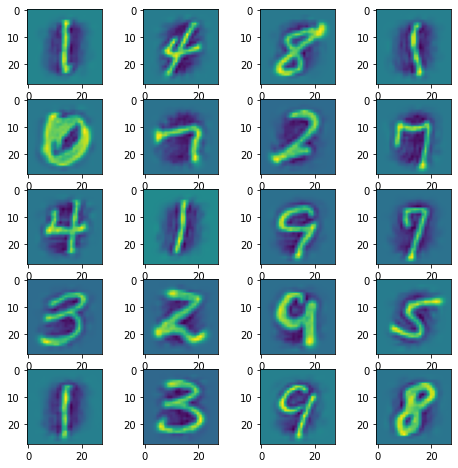

In [ ]:
idx = random.sample(range(1, 59000), 20)
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(0, columns*rows ):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i+1) 
    #print(idx[i])
    plt.imshow(Xhat[idx[i]].reshape((28,28))) 
plt.show()

### Reconstruction loss in PCA

In [ ]:
err = np.sum(np.sqrt(np.sum((Xhat - x_train)**2, axis=1)))
print("Total Reconstrucion Error : ",err )
print("Average Reconstrucion Error : ",err/60000 )

Total Reconstrucion Error :  93944602.65686816
Average Reconstrucion Error :  1565.7433776144694
